# Training code for creating a building segmentation model

**TL;DR**
* The notebook does the fol

#

In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
balraj98_massachusetts_buildings_dataset_path = kagglehub.dataset_download('balraj98/massachusetts-buildings-dataset')

print('Data source import complete.')


Data source import complete.


In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The dataset consists of $151$ aerial images of the Boston area. It covers mostly urban and suburban areas and buildings of all sizes. Each of the images has $1500 \times 1500$ pixels for an area of $2.25$ square kilometers. In total the dataset covers $340$ square kilometers area.

An accompanying **metadata.csv** is provided with each image ID, the split it belongs to, image urls and path to it.

In [6]:
IMG_ROOT = '/kaggle/input/massachusetts-buildings-dataset/'
df = pd.read_csv('/kaggle/input/massachusetts-buildings-dataset/metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']
print("Training dataset size:", len(train_df))
print("Test dataset size:", len(tst_df))

Training dataset size: 137
Test dataset size: 10


The image  is of the dimension 1500, 1500 with 3 RBG channels.

In [8]:
import cv2
import os
img = cv2.imread(os.path.join(IMG_ROOT, "/kaggle/input/massachusetts-buildings-dataset/tiff/train/22678975_15.tiff"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

(1500, 1500, 3)

This is the approach the source notebook uses where it is in much lower scale. The notebook resizes the images to (244, 244) and then uses them to train the model.
In my opinion this might cause information loss and the features are much less distint. 



We make a small change and take (244, 244) from the center and train the model using that. 


We can  be a little more greedy and extract many more crops from these images,  but  for the sake of simlicity we stick with just one crop from the center.

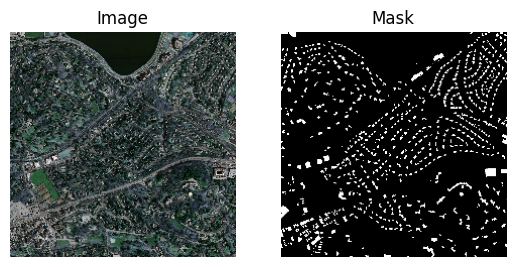

In [12]:
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])

class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.root+self.df.iloc[idx]['png_image_path']
        mask_path = self.root+self.df.iloc[idx]['png_label_path']
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        img = cv2.resize(img, (224, 224))
        mask = cv2.resize(mask, (224, 224))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return img, mask

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy()/255.)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks

tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tr_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[13]
fig, ax = plt.subplots(1, 2)
# fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()


Extracting the middle crop from the images

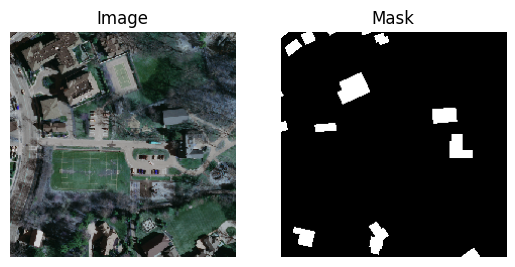

In [13]:
import random
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])


class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        crop_size = 224
        img_path = self.root + self.df.iloc[idx]['png_image_path']
        mask_path = self.root + self.df.iloc[idx]['png_label_path']

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Convert mask to grayscale
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Get original image dimensions
        H, W, _ = img.shape

        # Ensure crop size fits
        if H < crop_size or W < crop_size:
            raise ValueError(f"Image too small for 224x224 crop: {H}x{W}")

        # Pick random crop coordinates near the center
        center_x, center_y = W // 2, H // 2
        max_offset_x = (W - crop_size) // 2
        max_offset_y = (H - crop_size) // 2

        rand_offset_x = random.randint(max(0, center_x - max_offset_x), min(W - crop_size, center_x + max_offset_x))
        rand_offset_y = random.randint(max(0, center_y - max_offset_y), min(H - crop_size, center_y + max_offset_y))

        img_cropped = img[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]
        mask_cropped = mask[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]

        return img_cropped, mask_cropped

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy() / 255.0)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks


tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tr_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[13]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()


We define a Unet model for this task and use the `cross-entopy` loss for this and also track the model accuracy. 

In [14]:
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels,
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).to(device).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet().to(device)
model(torch.zeros((1, 3, 224, 224)).to(device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 87.9MB/s]


tensor([[[[-5.4322e-01,  4.8236e-01,  8.9122e-01,  ...,  2.2316e+00,
            5.0895e-01, -5.4612e-01],
          [ 1.4139e+00, -2.2463e+00,  2.9459e-01,  ...,  5.3234e-01,
            4.5568e-01, -2.8821e-02],
          [ 1.9838e+00, -1.5332e+00, -5.3104e-01,  ...,  8.2844e-01,
            1.6012e+00,  4.0500e-01],
          ...,
          [ 1.0512e+00, -8.9718e-01, -1.1316e-02,  ...,  2.6378e-01,
            1.2028e+00,  1.4459e-01],
          [ 2.2254e-01, -2.6198e+00, -1.1873e+00,  ..., -1.2981e+00,
           -8.8089e-02, -2.0641e-03],
          [ 4.8786e-01, -6.3906e-01, -4.1453e-01,  ..., -2.8132e-01,
            2.9503e-01,  1.1360e+00]],

         [[-5.8874e-01,  1.3280e+00,  1.7152e+00,  ...,  1.3266e+00,
            2.1138e+00,  2.4682e+00],
          [-4.1522e+00,  1.9877e-01, -1.3959e+00,  ..., -2.1493e-01,
           -5.6957e-01, -8.0767e-01],
          [-2.3266e+00,  5.2092e-01,  3.8252e-01,  ..., -3.3018e-01,
           -4.3430e-01,  7.9331e-02],
          ...,
     

We run the training for 50 epochs and track the training loss and validation loss as the training procgresses.

In [141]:
from tqdm import tqdm  # for progress bars

def loss_fn(preds, targets):
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()

model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

for epoch in range(n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Training loop
    pbar = tqdm(tr_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")
    for batch in pbar:
        loss, acc = train_batch(model, batch, optim, loss_fn)
        train_losses.append(loss)
        train_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Validation loop
    pbar = tqdm(tst_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")
    for batch in pbar:
        loss, acc = validate_batch(model, batch, loss_fn)
        val_losses.append(loss)
        val_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Epoch summary
    print(
        f"Epoch {epoch+1}/{n_epochs}: "
        f"Train Loss={sum(train_losses)/len(train_losses):.4f}, "
        f"Train Acc={sum(train_accs)/len(train_accs):.4f}, "
        f"Val Loss={sum(val_losses)/len(val_losses):.4f}, "
        f"Val Acc={sum(val_accs)/len(val_accs):.4f}"
    )


Epoch 1/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.16it/s, Loss=2.7338, Acc=0.9997]


Epoch 1/50: Train Loss=4.6835, Train Acc=0.5143, Val Loss=4.1599, Val Acc=0.6441


Epoch 2/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.05it/s, Loss=3.2607, Acc=1.0000]


Epoch 2/50: Train Loss=3.3168, Train Acc=0.6702, Val Loss=3.2356, Val Acc=0.8518


Epoch 3/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  6.98it/s, Loss=1.0426, Acc=0.9168]


Epoch 3/50: Train Loss=2.0894, Train Acc=0.6864, Val Loss=1.3454, Val Acc=0.8456


Epoch 4/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  6.98it/s, Loss=1.6079, Acc=0.6537]


Epoch 4/50: Train Loss=1.1677, Train Acc=0.7318, Val Loss=1.2788, Val Acc=0.7481


Epoch 5/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.08it/s, Loss=0.8468, Acc=0.7861]


Epoch 5/50: Train Loss=0.6478, Train Acc=0.8642, Val Loss=0.4218, Val Acc=0.9173


Epoch 6/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.21it/s, Loss=0.2519, Acc=0.9552]


Epoch 6/50: Train Loss=0.4547, Train Acc=0.8996, Val Loss=0.3436, Val Acc=0.9184


Epoch 7/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.38it/s, Loss=0.2323, Acc=0.9450]


Epoch 7/50: Train Loss=0.3391, Train Acc=0.9126, Val Loss=0.3155, Val Acc=0.9124


Epoch 8/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.34it/s, Loss=0.1314, Acc=0.9704]


Epoch 8/50: Train Loss=0.3211, Train Acc=0.9082, Val Loss=0.3038, Val Acc=0.8695


Epoch 9/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.38it/s, Loss=0.4723, Acc=0.8005]


Epoch 9/50: Train Loss=0.2767, Train Acc=0.9170, Val Loss=0.2760, Val Acc=0.9068


Epoch 10/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.36it/s, Loss=0.1864, Acc=0.9999]


Epoch 10/50: Train Loss=0.2693, Train Acc=0.9154, Val Loss=0.2575, Val Acc=0.9204


Epoch 11/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.37it/s, Loss=0.1045, Acc=0.9880]


Epoch 11/50: Train Loss=0.2429, Train Acc=0.9215, Val Loss=0.2420, Val Acc=0.9204


Epoch 12/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.35it/s, Loss=0.1846, Acc=0.9969]


Epoch 12/50: Train Loss=0.2695, Train Acc=0.9061, Val Loss=0.2466, Val Acc=0.9141


Epoch 13/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.07it/s, Loss=0.1396, Acc=0.9434]


Epoch 13/50: Train Loss=0.2215, Train Acc=0.9235, Val Loss=0.2056, Val Acc=0.9250


Epoch 14/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.02it/s, Loss=0.2595, Acc=0.9070]


Epoch 14/50: Train Loss=0.2346, Train Acc=0.9177, Val Loss=0.2197, Val Acc=0.9190


Epoch 15/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.07it/s, Loss=0.6220, Acc=0.7709]


Epoch 15/50: Train Loss=0.2356, Train Acc=0.9120, Val Loss=0.2218, Val Acc=0.9096


Epoch 16/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.01it/s, Loss=0.1768, Acc=0.9356]


Epoch 16/50: Train Loss=0.2239, Train Acc=0.9206, Val Loss=0.2240, Val Acc=0.9227


Epoch 17/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.11it/s, Loss=0.7332, Acc=0.5968]


Epoch 17/50: Train Loss=0.2325, Train Acc=0.9151, Val Loss=0.5611, Val Acc=0.7308


Epoch 18/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.18it/s, Loss=0.1151, Acc=0.9725]


Epoch 18/50: Train Loss=0.2244, Train Acc=0.9187, Val Loss=0.2199, Val Acc=0.9043


Epoch 19/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.24it/s, Loss=0.2107, Acc=0.9192]


Epoch 19/50: Train Loss=0.2159, Train Acc=0.9222, Val Loss=0.2032, Val Acc=0.9236


Epoch 20/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.41it/s, Loss=0.1853, Acc=0.9255]


Epoch 20/50: Train Loss=0.2193, Train Acc=0.9195, Val Loss=0.2021, Val Acc=0.9246


Epoch 21/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.42it/s, Loss=0.0111, Acc=1.0000]


Epoch 21/50: Train Loss=0.2138, Train Acc=0.9209, Val Loss=0.2086, Val Acc=0.9195


Epoch 22/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.41it/s, Loss=0.0447, Acc=0.9962]


Epoch 22/50: Train Loss=0.1963, Train Acc=0.9261, Val Loss=0.1989, Val Acc=0.9284


Epoch 23/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.34it/s, Loss=0.0120, Acc=1.0000]


Epoch 23/50: Train Loss=0.1927, Train Acc=0.9271, Val Loss=0.2058, Val Acc=0.9235


Epoch 24/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.38it/s, Loss=0.2410, Acc=0.9022]


Epoch 24/50: Train Loss=0.2029, Train Acc=0.9223, Val Loss=0.1974, Val Acc=0.9246


Epoch 25/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.36it/s, Loss=0.4295, Acc=0.8588]


Epoch 25/50: Train Loss=0.2087, Train Acc=0.9216, Val Loss=0.1947, Val Acc=0.9192


Epoch 26/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.33it/s, Loss=0.0873, Acc=0.9709]


Epoch 26/50: Train Loss=0.1906, Train Acc=0.9300, Val Loss=0.1938, Val Acc=0.9298


Epoch 27/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.17it/s, Loss=0.7596, Acc=0.6938]


Epoch 27/50: Train Loss=0.1906, Train Acc=0.9303, Val Loss=0.2081, Val Acc=0.9227


Epoch 28/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.15it/s, Loss=0.1160, Acc=0.9588]


Epoch 28/50: Train Loss=0.1776, Train Acc=0.9341, Val Loss=0.1995, Val Acc=0.9259


Epoch 29/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.07it/s, Loss=0.1470, Acc=0.9471]


Epoch 29/50: Train Loss=0.2005, Train Acc=0.9253, Val Loss=0.1924, Val Acc=0.9284


Epoch 30/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.04it/s, Loss=0.1530, Acc=0.9615]


Epoch 30/50: Train Loss=0.2046, Train Acc=0.9211, Val Loss=0.2002, Val Acc=0.9242


Epoch 31/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.07it/s, Loss=0.0791, Acc=0.9761]


Epoch 31/50: Train Loss=0.1956, Train Acc=0.9252, Val Loss=0.2024, Val Acc=0.9194


Epoch 32/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.00it/s, Loss=0.1794, Acc=0.9197]


Epoch 32/50: Train Loss=0.1953, Train Acc=0.9255, Val Loss=0.1731, Val Acc=0.9332


Epoch 33/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.17it/s, Loss=0.2678, Acc=0.8835]


Epoch 33/50: Train Loss=0.1876, Train Acc=0.9287, Val Loss=0.1727, Val Acc=0.9344


Epoch 34/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.19it/s, Loss=0.1289, Acc=0.9530]


Epoch 34/50: Train Loss=0.1849, Train Acc=0.9280, Val Loss=0.1759, Val Acc=0.9360


Epoch 35/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.45it/s, Loss=0.1826, Acc=0.9277]


Epoch 35/50: Train Loss=0.1856, Train Acc=0.9299, Val Loss=0.1703, Val Acc=0.9367


Epoch 36/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.39it/s, Loss=0.0124, Acc=0.9988]


Epoch 36/50: Train Loss=0.1897, Train Acc=0.9278, Val Loss=0.1701, Val Acc=0.9375


Epoch 37/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.41it/s, Loss=0.2768, Acc=0.8851]


Epoch 37/50: Train Loss=0.1915, Train Acc=0.9274, Val Loss=0.1831, Val Acc=0.9302


Epoch 38/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.38it/s, Loss=0.0261, Acc=0.9973]


Epoch 38/50: Train Loss=0.1908, Train Acc=0.9292, Val Loss=0.1952, Val Acc=0.9272


Epoch 39/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.40it/s, Loss=0.0087, Acc=1.0000]


Epoch 39/50: Train Loss=0.2014, Train Acc=0.9248, Val Loss=0.1963, Val Acc=0.9235


Epoch 40/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.45it/s, Loss=0.2113, Acc=0.9456]


Epoch 40/50: Train Loss=0.1988, Train Acc=0.9231, Val Loss=0.1781, Val Acc=0.9293


Epoch 41/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.40it/s, Loss=0.0176, Acc=1.0000]


Epoch 41/50: Train Loss=0.1832, Train Acc=0.9322, Val Loss=0.1650, Val Acc=0.9375


Epoch 42/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.41it/s, Loss=0.0764, Acc=0.9730]


Epoch 42/50: Train Loss=0.2119, Train Acc=0.9223, Val Loss=0.1742, Val Acc=0.9319


Epoch 43/50 [Validation]: 100%|██████████| 137/137 [00:18<00:00,  7.22it/s, Loss=1.3920, Acc=0.3821]


Epoch 43/50: Train Loss=0.1948, Train Acc=0.9252, Val Loss=0.2725, Val Acc=0.8852


Epoch 44/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.18it/s, Loss=0.0870, Acc=0.9719]


Epoch 44/50: Train Loss=0.1889, Train Acc=0.9271, Val Loss=0.1751, Val Acc=0.9315


Epoch 45/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.09it/s, Loss=0.1607, Acc=0.9372]


Epoch 45/50: Train Loss=0.1760, Train Acc=0.9326, Val Loss=0.1589, Val Acc=0.9385


Epoch 46/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.00it/s, Loss=0.0125, Acc=1.0000]


Epoch 46/50: Train Loss=0.1878, Train Acc=0.9306, Val Loss=0.1699, Val Acc=0.9349


Epoch 47/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.05it/s, Loss=0.0906, Acc=0.9753]


Epoch 47/50: Train Loss=0.1672, Train Acc=0.9378, Val Loss=0.1647, Val Acc=0.9356


Epoch 48/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.04it/s, Loss=0.6664, Acc=0.7235]


Epoch 48/50: Train Loss=0.1871, Train Acc=0.9258, Val Loss=0.1869, Val Acc=0.9242


Epoch 49/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.04it/s, Loss=0.1036, Acc=0.9634]


Epoch 49/50: Train Loss=0.1801, Train Acc=0.9303, Val Loss=0.1722, Val Acc=0.9341


Epoch 50/50 [Validation]: 100%|██████████| 137/137 [00:19<00:00,  7.07it/s, Loss=0.5082, Acc=0.8041]

Epoch 50/50: Train Loss=0.1919, Train Acc=0.9253, Val Loss=0.2013, Val Acc=0.9218


In [ ]:
log.plot_epochs(['trn_loss', 'val_loss'])

In [143]:
with open("/content/model2.pt", "wb") as f:
    torch.save(model.state_dict(), f)
# torch.save(model)

Testing the models performence on 

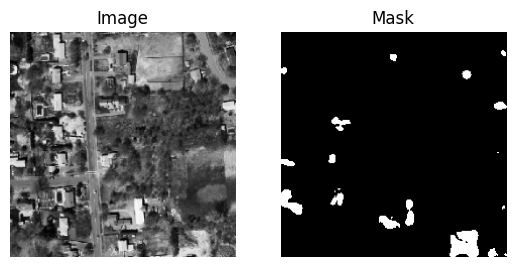

In [69]:
# Preprocess the image
test_image = final_images[1][:224, :224, :]

# Apply same transforms as training
test_im_tensor = tfms(test_image).unsqueeze(0).to(device)  # Normalize, add batch dim

# Ensure float32 (model expects float32)
test_im_tensor = test_im_tensor.float()

# Run through model
with torch.no_grad():
    _mask = model(test_im_tensor)
_, _mask = torch.max(_mask, dim=1)


fig, ax = plt.subplots(1, 2)
# fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_image[:, :, 0], cmap = "gray")
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()


In [53]:
_mask.shape

torch.Size([1, 224, 224])

In [22]:
model(torch.zeros((1, 3, 224, 224)).to(device))


tensor([[[[ 5.2035,  5.1788,  5.4592,  ...,  5.3129,  5.0148,  4.9395],
          [ 4.8906,  5.5884,  5.7218,  ...,  5.4984,  4.8361,  4.8922],
          [ 5.3919,  5.7618,  5.8386,  ...,  5.5199,  4.8398,  4.9044],
          ...,
          [ 5.0682,  5.6208,  6.0924,  ...,  6.0112,  5.6240,  5.5763],
          [ 4.9951,  5.4800,  5.7261,  ...,  5.8583,  5.7156,  5.7006],
          [ 5.0342,  5.2912,  5.4261,  ...,  5.4031,  5.3161,  5.5727]],

         [[-3.3754, -3.3831, -3.3953,  ..., -3.6804, -3.3963, -3.5035],
          [-3.0531, -3.7533, -3.6967,  ..., -3.6965, -3.5206, -3.4236],
          [-3.1870, -3.8407, -3.7034,  ..., -3.8447, -3.3769, -3.4019],
          ...,
          [-3.0417, -3.7426, -3.8784,  ..., -4.0604, -3.8927, -3.8403],
          [-3.1314, -3.7393, -3.7261,  ..., -4.0510, -3.8938, -3.9770],
          [-3.0143, -3.5023, -3.4487,  ..., -3.6885, -3.6753, -3.9807]],

         [[-2.7347, -2.8724, -2.9660,  ..., -3.0155, -2.7831, -2.7604],
          [-2.7199, -3.3848, -

In [30]:
im, mask = next(iter(tst_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

AttributeError: Figure.set() got an unexpected keyword argument 'nc'

In [105]:
_mask.shape

torch.Size([1, 224, 224])

In [51]:
test_image = final_images[1]
test_im_tensor = torch.tensor(test_image).float()
test_im_tensor = test_im_tensor.permute(2, 0, 1)
test_im_tensor = test_im_tensor.unsqueeze(0)
test_im_tensor = test_im_tensor.to(device)
test_im_tensor.shape

torch.Size([1, 3, 224, 224])

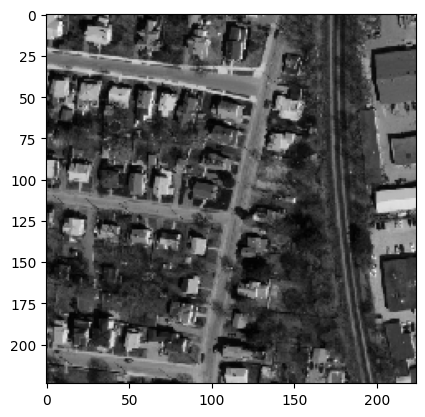

In [167]:
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0], cmap = "gray")

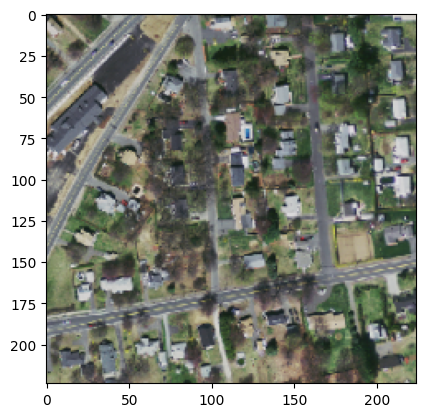

In [163]:
plt.imshow(final_images[0])

In [33]:
im.shape, _mask.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 224, 224]))

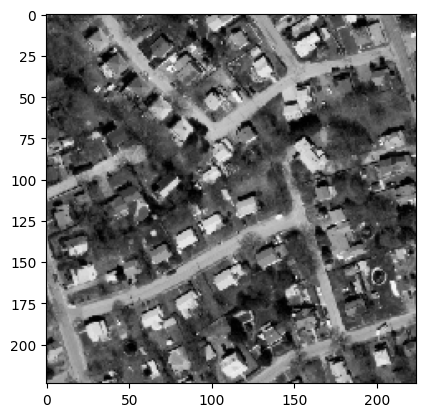

In [50]:
im, mask = next(iter(tst_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
im = im.squeeze()
# subplots([im.permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
# ,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
# nc=3, titles=['Original image','Original mask','Predicted mask'])

plt.imshow(im.permute(1,2,0).detach().cpu()[:,:,0], cmap = "gray")

Code to save the model.

In [178]:
# Save the full model
torch.save(model, "Models/unet_model_buildings.pt")


In [18]:
unet_model = torch.load('Models/unet_model_buildings.pt', map_location=device, weights_only=False)
